In [1]:
from mae.encoder import *
from mae.decoder import *
from dataset import *
import gin

In [2]:
gin.parse_config_file("config/encoder_config1.gin")
encoder_config = EncoderConfig()

gin.parse_config_file("config/decoder_config1.gin")
decoder_config = DecoderConfig()

In [3]:
decoder_config

DecoderConfig(image_size=128, in_proj_dim=256, hidden_size=256, intermediate_size=768, num_hidden_layers=4, num_attention_heads=2, num_channels=3, patch_size=8, norm_eps=1e-08, attention_dropout=0.0, do_loss_calculation=True, use_small_mlp=False, num_image_tokens=256, head_dim=128, patched_image_height=16, patched_image_width=16)

In [4]:
encoder = Encoder(encoder_config)
decoder = Decoder(decoder_config)

In [5]:
# # initialize the parameters of the encoder
# def initialize_encoder_parameters(module):
#     if isinstance(module, nn.Linear):
#         nn.init.xavier_uniform_(module.weight)
#         if module.bias is not None:
#             nn.init.zeros_(module.bias)
#     elif isinstance(module, nn.Embedding):
#         nn.init.normal_(module.weight, mean=0.0, std=0.02)
#     elif isinstance(module, nn.LayerNorm):
#         nn.init.constant_(module.weight, 1.0)
#         nn.init.constant_(module.bias, 0.0)

# encoder.apply(initialize_encoder_parameters)

In [6]:
# img, class_name = next(iter(train_dataloader))
# img.shape, class_name

# sample input 
img = torch.randn(1, 3, 128, 128)

In [7]:
encoder_op, mask, ids_restore = encoder(img)
decoder_op = decoder((encoder_op, mask, ids_restore), img)

In [8]:
decoder_op[1]

tensor(1.2878, grad_fn=<MseLossBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1218333..2.2351327].


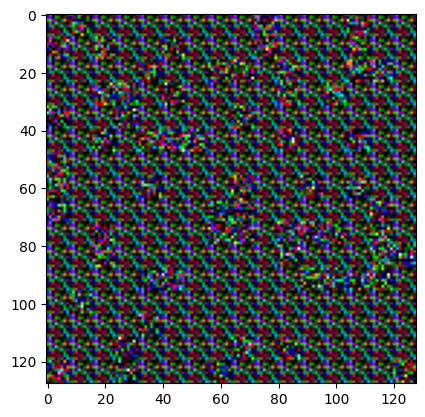

In [9]:
import matplotlib.pyplot as plt
plt.imshow(decoder_op[0].squeeze(0).detach().cpu().permute(1, 2, 0));

In [10]:
from dataset import *

In [11]:
import os
files = os.listdir("dataset")
ds = Birddataset("dataset/", allowed_classes=files, dataset_type="train", do_transform=True)

In [12]:
train_dataset = Birddataset("dataset", ["budgie", "canary", "duckling", "rubber duck", "unlabeled"], "train")
test_dataset = Birddataset("dataset", ["budgie", "canary", "duckling", "rubber duck", "unlabeled"], "test")

In [13]:
train_dataset.__len__()
test_dataset.__len__()

12

In [14]:
train_dataset.__getitem__(0)

(tensor([[[-0.6623, -0.5424, -0.5938,  ...,  0.6221,  0.9132,  0.9132],
          [-0.7650, -0.5596, -0.5767,  ...,  0.7762,  0.8961,  0.7077],
          [-0.5596, -0.4054, -0.4226,  ...,  0.8789,  0.9474,  0.7933],
          ...,
          [-1.6898, -1.5357, -1.3302,  ..., -0.6452, -1.9295, -1.9980],
          [-1.6898, -1.7583, -1.8097,  ..., -0.9192,  2.2489,  0.0569],
          [-2.1179, -1.4672, -1.4672,  ...,  0.8789, -0.9020,  0.2796]],
 
         [[-0.9503, -0.8277, -0.8627,  ...,  0.4853,  0.7829,  0.7829],
          [-1.0553, -0.8277, -0.8452,  ...,  0.6429,  0.7654,  0.5728],
          [-0.8277, -0.6702, -0.6877,  ...,  0.7829,  0.8529,  0.6954],
          ...,
          [-1.4755, -1.3529, -1.1779,  ..., -1.3529, -1.7556, -1.3704],
          [-1.2654, -1.4755, -1.8782,  ..., -1.3179,  1.7283, -0.5826],
          [-1.7731, -1.1604, -1.5980,  ...,  0.6779, -1.8957, -1.0203]],
 
         [[-1.0376, -0.9156, -1.0027,  ..., -0.1487,  0.1476,  0.1476],
          [-1.1421, -0.9678,

In [15]:
from model import *

In [16]:
mae_config = MAEWrapperConfig(lr=3e-4,
                       batch_size=8,
                       num_epochs=10,
                       weight_decay=0.0001,
                       eps=1e-8,
                       seed=42,
                       betas=(0.9, 0.999),
                       gpu_count=1)

In [17]:
wrapper = MAEWrapper(encoder, decoder, config=mae_config)

AttributeError: 'MAEWrapper' object has no attribute 'model'